In [162]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.neighbors import KernelDensity
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'font.size': 30,
                            'font.family': 'serif',
                            'lines.markersize': 8})


# Dataset

## Generate data

In [163]:
def generate_data():
    """
    Generate the toy data.

    Returns:
        X_train, Y_train, X_test, Y_test
    """
    maxn = 1600
    X = np.zeros((maxn, 2))
    X[:, 0] = np.random.uniform(-1.95, 1.95, maxn)
    X[:, 1] = np.random.uniform(-0.95, 0.95, maxn)
    y = np.zeros(maxn, dtype=np.int64)

    idx_list = [None] * 4
    idx_list[0] = (X[:, 0] <= 0) & (X[:, 1] > 0)
    idx_list[1] = (X[:, 0] <= 0) & (X[:, 1] <= 0)
    idx_list[2] = (X[:, 0] > 0) & (X[:, 0] <= 1)
    idx_list[3] = (X[:, 0] > 1)

    for i in range(maxn):
        if ((X[i, 0] - 1) ** 2 + (X[i, 1] - 0.5) ** 2) <= 0.5 ** 2:  # in upper circle
            idx_list[2][i] = True
            idx_list[3][i] = False
        if ((X[i, 0] - 1) ** 2 + (X[i, 1] + 0.5) ** 2) <= 0.5 ** 2:  # in lower circle
            idx_list[2][i] = False
            idx_list[3][i] = True

    for i in range(4):
        y[idx_list[i]] = i

    for i in range(maxn):
        if (y[i] == 0 or y[i] == 1):
            X[i, 0] -= 0.05
            if y[i] == 0:
                X[i, 1] += 0.05
            else:
                X[i, 1] -= 0.05
        if y[i] == 2:
            X[i, 0] += 0.05
            X[i, 1] *= (1 / 0.95)
        if y[i] == 3:
            X[i, 0] += 0.1
            X[i, 1] *= (1 / 0.95)

    maxn_add = int(maxn / 4)
    X_add = np.zeros((maxn_add, 2))
    X_add[:, 0] = np.random.uniform(-2, 2, maxn_add)
    X_add[:, 1] = np.random.uniform(1.01, 1.5, maxn_add)
    y_add = np.array([4] * maxn_add)
    y = np.concatenate((y, y_add), axis=0)
    X = np.concatenate((X, X_add), axis=0)
    Y_multiclass = np.zeros(y.shape, np.int64)
    n_class = len(np.unique(y))
    for i in range(n_class):
        Y_multiclass[y == i] = i
    y = Y_multiclass
    random_idx = np.random.permutation(maxn + maxn_add)
    half_idx = int(np.round((maxn + maxn_add) / 2))

    y = y[random_idx]
    X = X[random_idx]
    Y_test = y[half_idx:]
    X_test = X[half_idx:]
    X_train = X[:half_idx]
    Y_train = y[:half_idx]
    return X_train, Y_train, X_test, Y_test


def scatterplot(X, Y, title, figsize=(8, 8), palette='deep', xlim=None, ylim=None):
    """
    Plot the scatterplot.
    """
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(data={'x': X[:, 0], 'y': X[:, 1], 'class': Y},
                         x='x', y='y', hue='class', palette=palette, legend='brief')
    ax.set_title(title)
    ax.legend(loc='right')
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    return ax


FIGSIZE = (8, 8)
COLORSCHEME = np.array(['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2', '#999999'])

generate data

In [164]:
np.random.seed(0)
x_train, y_train, x_test, y_test = generate_data()
xlim = x_train[:, 0].min() - 0.1, x_train[:, 0].max() + 0.1
ylim = x_train[:, 1].min() - 0.1, x_train[:, 1].max() + 0.1

In [165]:
print('Training data:')
print('X_train:', x_train.shape)
print('Y_train:', y_train.shape)

print('Testing data:')
print('X_test:', x_test.shape)
print('Y_test:', y_test.shape)

Training data:
X_train: (1000, 2)
Y_train: (1000,)
Testing data:
X_test: (1000, 2)
Y_test: (1000,)


visualization

training dataset:


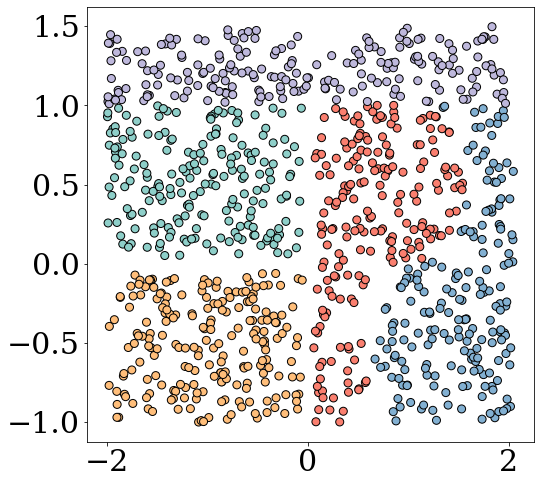

In [166]:
print('training dataset:')

fig, ax = plt.subplots(figsize=FIGSIZE)

scatter = ax.scatter(x=x_train[:, 0],
                     y=x_train[:, 1],
                     c=COLORSCHEME[y_train],
                     edgecolors='#000000')

plt.show()

training dataset:


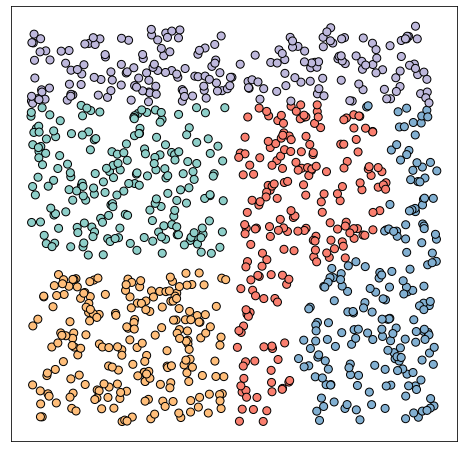

In [187]:
print('training dataset:')

fig, ax = plt.subplots(figsize=FIGSIZE)

scatter = ax.scatter(x=x_train[:, 0],
                     y=x_train[:, 1],
                     c=COLORSCHEME[y_train],
                     edgecolors='#000000')
plt.xticks(())
plt.yticks(())
plt.show()

testing dataset:


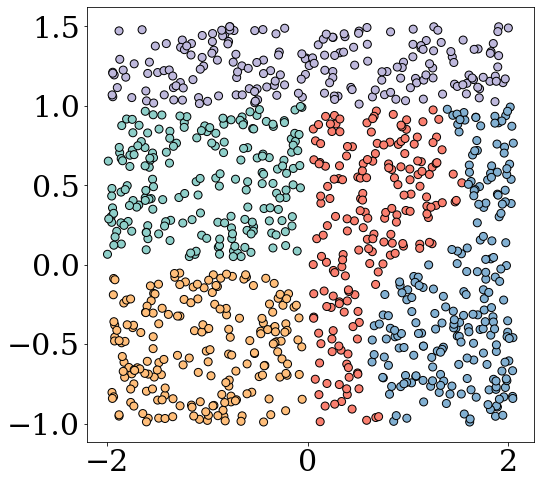

In [167]:
print('testing dataset:')

fig, ax = plt.subplots(figsize=FIGSIZE)

scatter = ax.scatter(x=x_test[:, 0],
                     y=x_test[:, 1],
                     c=COLORSCHEME[y_test],
                     edgecolors='#000000')

plt.show()

## Split dataset to 3 parties

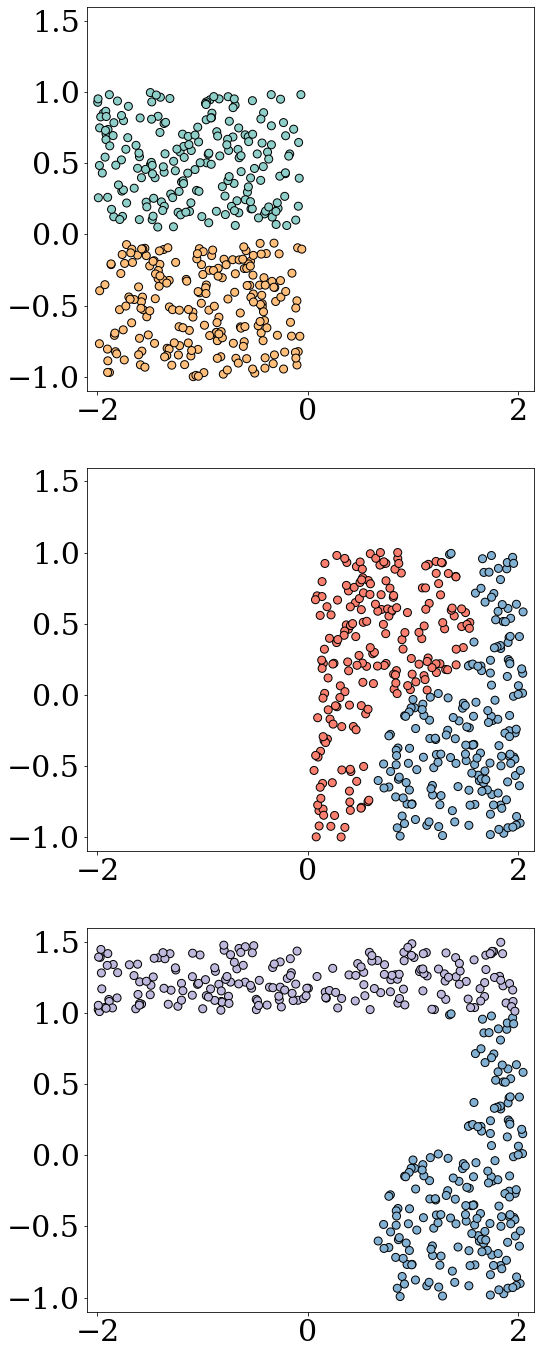

In [168]:
def separate_data(X_train: np.ndarray, Y_train: np.ndarray):
    """
    Separate the toy data to three parties.

    Args:
        X_train: the training data.
        Y_train: the training labels.

    Returns:
        X_train_1, Y_train_1, X_train_2, Y_train_2, X_train_3, Y_train_3
    """
    n_class = 5
    c_split = [[0, 1], [2, 3], [3, 4]]

    idx_1 = Y_train <= c_split[0][1]
    idx_2 = (Y_train >= c_split[1][0]) & (Y_train <= c_split[1][1])
    idx_3 = Y_train >= c_split[2][0]

    X_1 = X_train[idx_1]
    X_2 = X_train[idx_2]
    X_3 = X_train[idx_3]

    Y_1 = Y_train[idx_1]
    Y_2 = Y_train[idx_2]
    Y_3 = Y_train[idx_3]
    return X_1, Y_1, X_2, Y_2, X_3, Y_3


x_1, y_1, x_2, y_2, x_3, y_3 = separate_data(x_train, y_train)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*3))

ax = ax1
scatter = ax.scatter(x=x_1[:, 0],
                     y=x_1[:, 1],
                     c=COLORSCHEME[y_1],
                     edgecolors='#000000')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = ax2
scatter = ax.scatter(x=x_2[:, 0],
                     y=x_2[:, 1],
                     c=COLORSCHEME[y_2],
                     edgecolors='#000000')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = ax3

scatter = ax.scatter(x=x_3[:, 0],
                     y=x_3[:, 1],
                     c=COLORSCHEME[y_3],
                     edgecolors='#000000')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()


# Models

In [169]:
class LocalModel:
    def __init__(self, classifier, density_estimator):
        super().__init__()
        self.classifier = classifier
        self.density_estimator = density_estimator

    def fit(self,x_train, y_train):
        self.classifier.fit(x_train, y_train)
        self.density_estimator.fit(x_train)

    def predict(self,x):
        return self.classifier.predict(x)

    def predict_proba(self,x):
        "p(c|x)"
        return self.classifier.predict_proba(x)
    
    def log_likelihood(self, x):
        "log(p(x))"
        log_px = self.density_estimator.score_samples(x)
        return log_px

## Model 1

In [170]:
from sklearn.linear_model import LogisticRegression
model_1 = LocalModel(LogisticRegression(), KernelDensity(bandwidth=0.1))
model_1.fit(x_1, y_1)

plot decision region of model 1

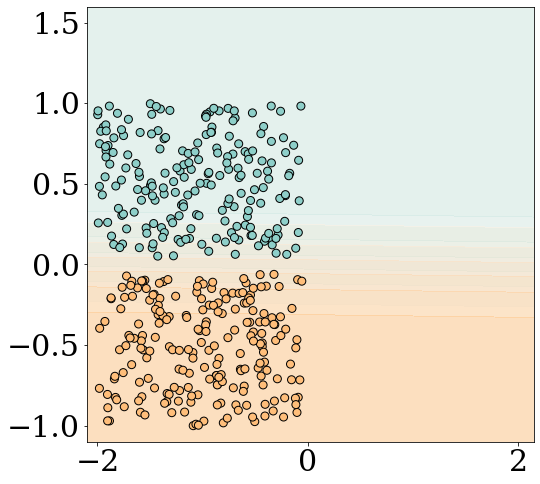

In [171]:
import matplotlib as mpl

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
z = model_1.predict_proba(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape[0], xx.shape[1], 2)

fig, ax = plt.subplots(figsize=FIGSIZE)

cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', ['#FFFFFF', COLORSCHEME[0]], N=100)
contour = ax.contourf(xx, yy, z[:, :, 0], cmap=cmap, alpha=0.5)

cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', ['#FFFFFF', COLORSCHEME[1]], N=100)
contour = ax.contourf(xx, yy, z[:, :, 1], cmap=cmap, alpha=0.5)

# Plot also the training points
ax.scatter(x_1[:, 0], x_1[:, 1], c=COLORSCHEME[y_1], edgecolors="#000000")
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()


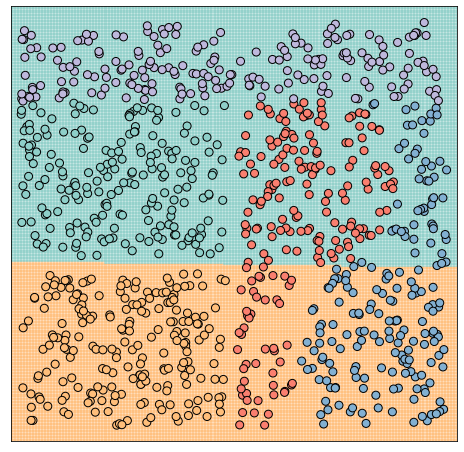

In [189]:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300))
z = model_1.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure(figsize=(8, 8))

cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [COLORSCHEME[0], COLORSCHEME[1]], N=100)
plt.pcolormesh(xx, yy, z, cmap=cmap, shading='auto', alpha=0.5)

# Plot also the training points
# plt.scatter(x_1[:, 0], x_1[:, 1], c=COLORSCHEME[y_1], edgecolors="#000000")
plt.scatter(x_train[:, 0], x_train[:, 1], c=COLORSCHEME[y_train], edgecolors="#000000")


plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(())
plt.yticks(())

plt.show()


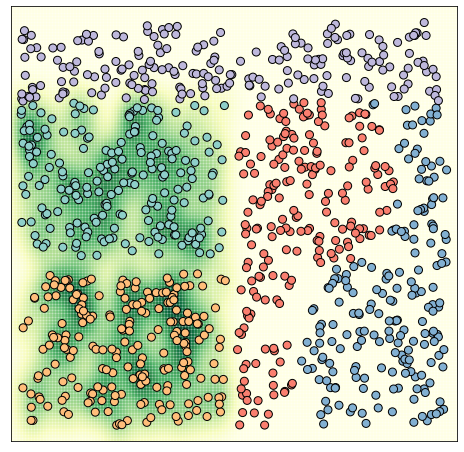

In [192]:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300))
z = np.exp(model_1.log_likelihood(np.c_[xx.ravel(), yy.ravel()]))
z = z.reshape(xx.shape)

plt.figure(figsize=(8, 8))

cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [COLORSCHEME[0], COLORSCHEME[1]], N=100)
plt.pcolormesh(xx, yy, z, cmap='YlGn', shading='auto', alpha=0.5)

# Plot also the training points
# plt.scatter(x_1[:, 0], x_1[:, 1], c=COLORSCHEME[y_1], edgecolors="#000000")
plt.scatter(x_train[:, 0], x_train[:, 1], c=COLORSCHEME[y_train], edgecolors="#000000")


plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(())
plt.yticks(())

plt.show()


## Model 2

In [173]:
from sklearn.svm import SVC
model_2 = LocalModel(SVC(kernel='rbf', probability=True, decision_function_shape='ovo', tol=1e-4),
                     KernelDensity(bandwidth=0.1))
model_2.fit(x_2, y_2)


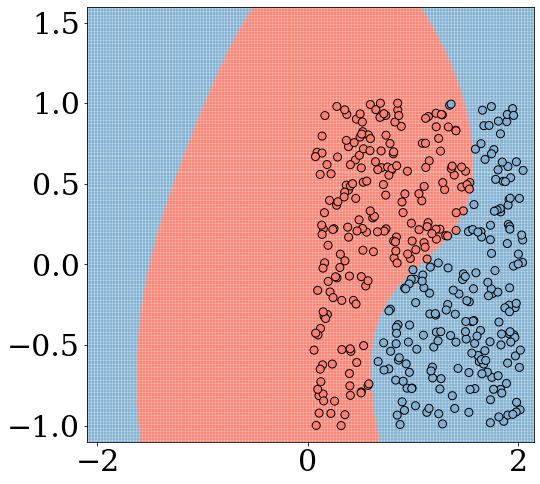

In [174]:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300))
z = model_2.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure(figsize=FIGSIZE)

cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [COLORSCHEME[2], COLORSCHEME[3]], N=100)
plt.pcolormesh(xx, yy, z, cmap=cmap, shading='auto', alpha=0.5)

# Plot also the training points
plt.scatter(x_2[:, 0], x_2[:, 1], c=COLORSCHEME[y_2], edgecolors="#000000")


plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


## Model 3

In [175]:
from sklearn.ensemble import GradientBoostingClassifier
model_3 = LocalModel(GradientBoostingClassifier(), KernelDensity(bandwidth=0.1))
model_3.fit(x_3, y_3)


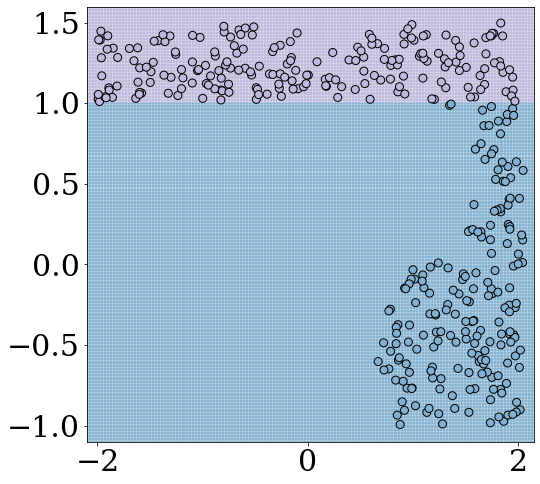

In [176]:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300))
z = model_3.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure(figsize=FIGSIZE)
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [COLORSCHEME[3], COLORSCHEME[4]], N=100)
ax = plt.pcolormesh(xx, yy, z, cmap=cmap, shading='auto', alpha=0.5)

# Plot also the training points
plt.scatter(x_3[:, 0], x_3[:, 1], c=COLORSCHEME[y_3], edgecolors="#000000")

plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


# Model ensembel and evaluate

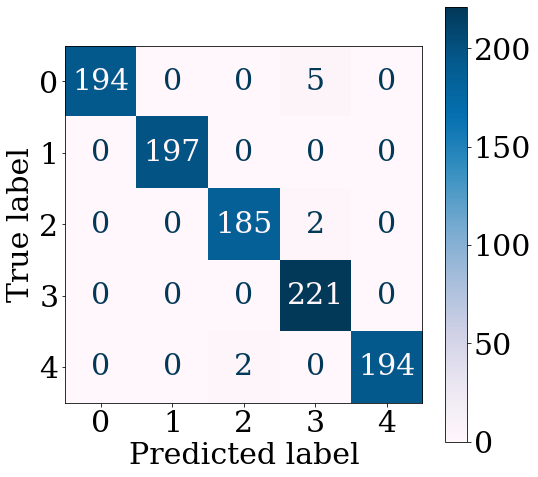

accuracy: 0.991


In [177]:
def global_predict(X):
    batch_size = X.shape[0]
    num_classes = 5
    classes = ([0, 1], [2, 3], [3, 4])
    num_samples = np.array((len(x_1), len(x_2), len(x_3)))
    num_parties = len(classes)

    # prior p(S)
    prior = num_samples / np.sum(num_samples)
    prior = prior.reshape((1, num_parties, 1))

    # posterior p(C|x,S)
    posterior = np.zeros((batch_size, num_parties, num_classes))
    posterior[:, 0, classes[0]] = model_1.predict_proba(X)
    posterior[:, 1, classes[1]] = model_2.predict_proba(X)
    posterior[:, 2, classes[2]] = model_3.predict_proba(X)

    # log likelihood log p(x|S)
    log_likelihood = np.zeros((batch_size, num_parties))
    log_likelihood[:, 0] = model_1.log_likelihood(X)
    log_likelihood[:, 1] = model_2.log_likelihood(X)
    log_likelihood[:, 2] = model_3.log_likelihood(X)
    log_likelihood -= np.max(log_likelihood, axis=-1, keepdims=True) # normalize
    log_likelihood = log_likelihood.reshape((batch_size, num_parties, 1))

    objective = prior * posterior * np.exp(log_likelihood)
    objective = objective.sum(axis=1)

    y_pred = np.argmax(objective, axis=1)
    return y_pred, objective


y_pred, objective = global_predict(x_test)
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(5)))

fig, ax = plt.subplots(figsize=FIGSIZE)

disp.plot(ax=ax, cmap='PuBu')#, colorbar=False)
plt.show()

print('accuracy:', sklearn.metrics.accuracy_score(y_test, y_pred))


In [178]:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300))
xy = np.c_[xx.ravel(), yy.ravel()]

y_pred, objective = global_predict(xy)
y_pred = y_pred.reshape(xx.shape)

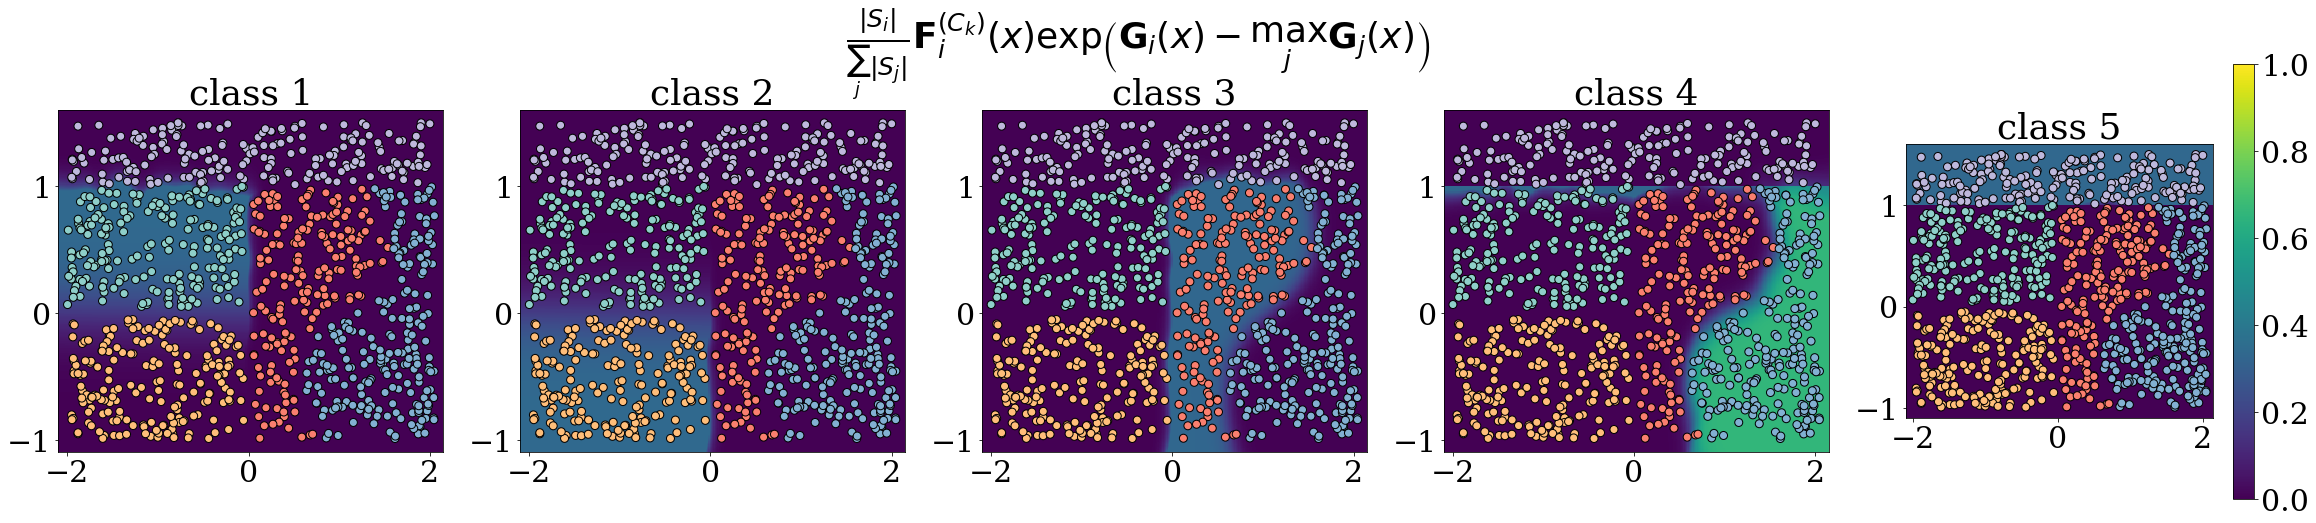

In [179]:
fig, axes = plt.subplots(1, 5, figsize=(8 * 5, 8))
fig.suptitle(R'$\frac{|S_i|}{\sum_j|S_j|} \mathbf{F}_i^{(C_k)}(x) \exp\left(\mathbf{G}_i(x) - \max_j {\mathbf{G}_j(x)} \right)$')
for i in range(5):
    obj = objective[:, i]
    obj = obj.reshape(xx.shape)

    ax = axes[i]
    ax.set_aspect(1.4)
    ax.set_title(f'class {i+1}')
    density = ax.pcolormesh(xx, yy, obj, shading='auto', cmap='viridis', vmin=0, vmax=1)

    # Plot also the testing data points
    ax.scatter(x_test[:, 0], x_test[:, 1], c=COLORSCHEME[y_test], edgecolors="k")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
fig.colorbar(density)
plt.show()


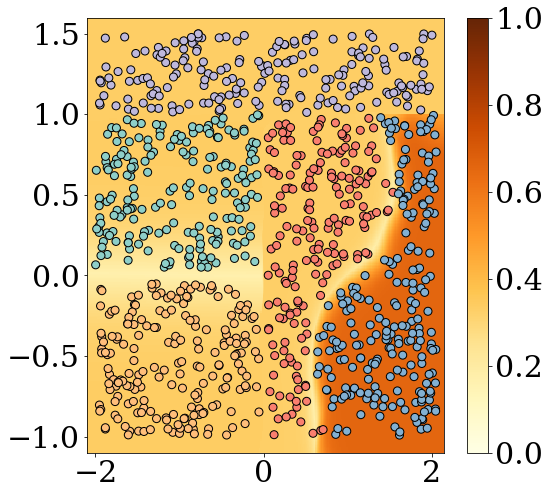

In [180]:
fig, ax = plt.subplots(figsize=FIGSIZE)
obj = objective.max(axis=1)
obj = obj.reshape(xx.shape)

density = ax.pcolormesh(xx, yy, obj, shading='auto', cmap='YlOrBr', vmin=0, vmax=1)
fig.colorbar(density)

# Plot also the testing data points
ax.scatter(x_test[:, 0], x_test[:, 1], c=COLORSCHEME[y_test], edgecolors="k")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()


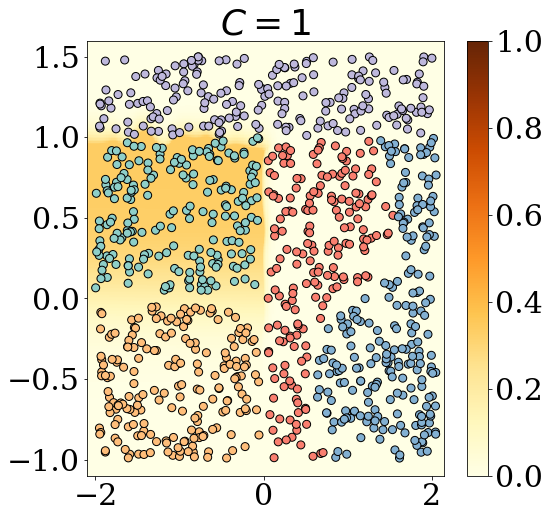

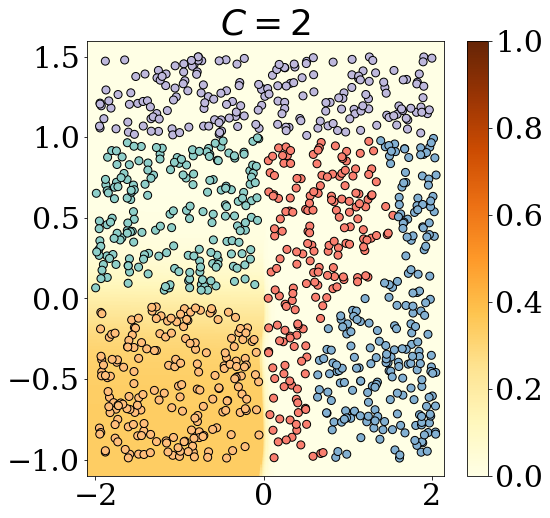

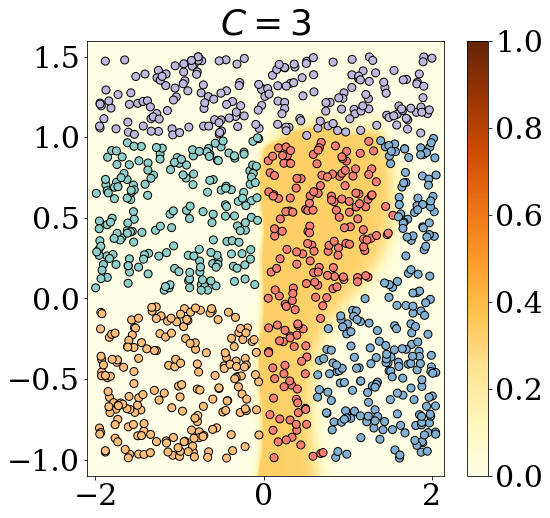

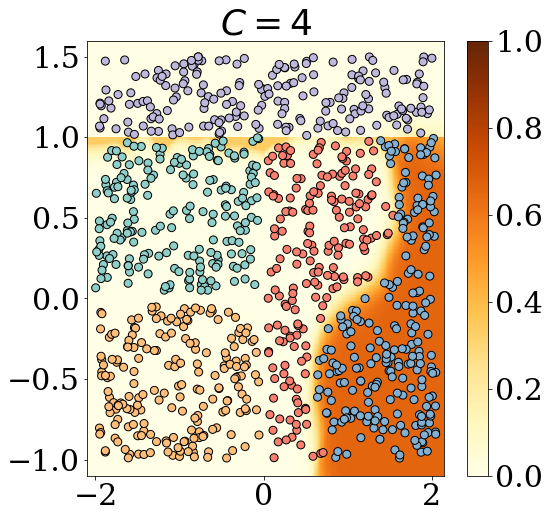

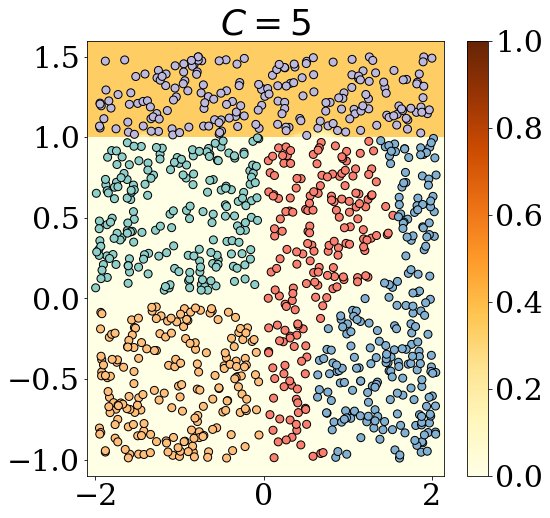

In [181]:
for i in range(5):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    obj = objective[:, i]
    obj = obj.reshape(xx.shape)

    ax.set_title(f'$C={i+1}$')
    density = ax.pcolormesh(xx, yy, obj, shading='auto', cmap='YlOrBr', vmin=0, vmax=1)
    fig.colorbar(density)

    # Plot also the testing data points
    ax.scatter(x_test[:, 0], x_test[:, 1], c=COLORSCHEME[y_test], edgecolors="k")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()


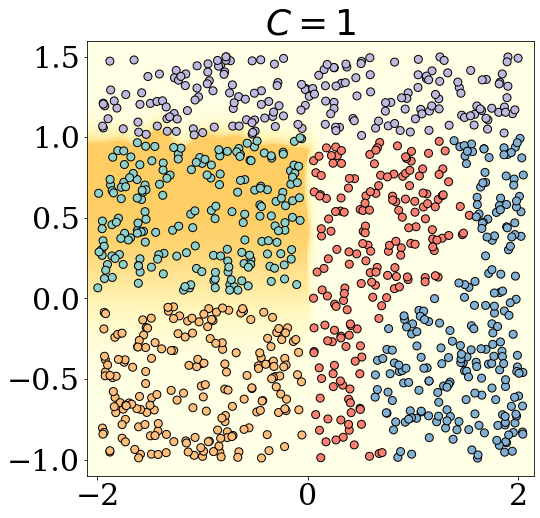

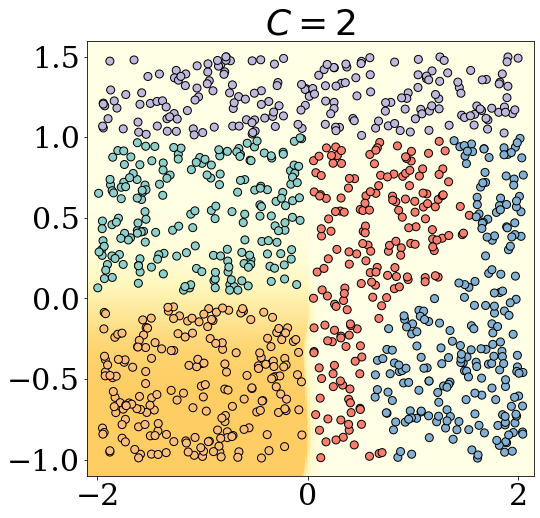

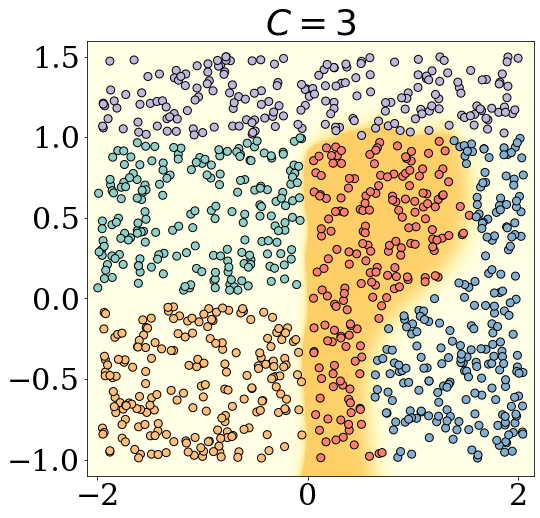

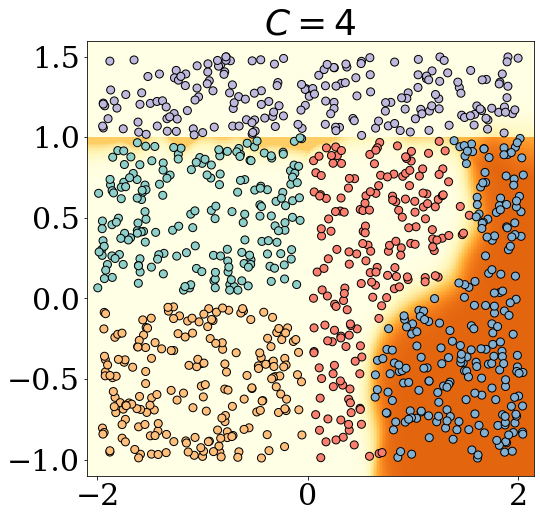

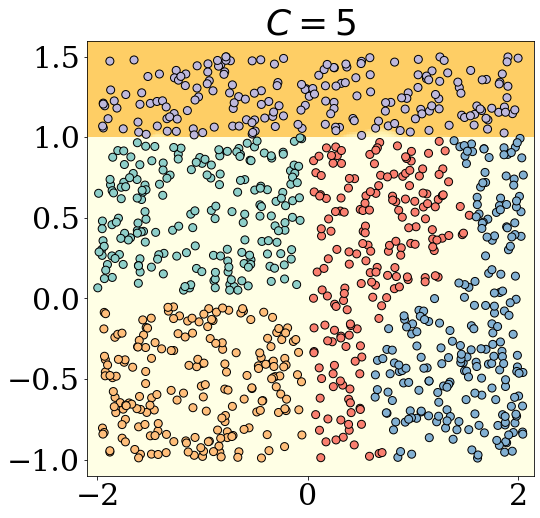

In [182]:
for i in range(5):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    obj = objective[:, i]
    obj = obj.reshape(xx.shape)

    ax.set_title(f'$C={i+1}$')
    density = ax.pcolormesh(xx, yy, obj, shading='auto', cmap='YlOrBr', vmin=0, vmax=1)

    # Plot also the testing data points
    ax.scatter(x_test[:, 0], x_test[:, 1], c=COLORSCHEME[y_test], edgecolors="k")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

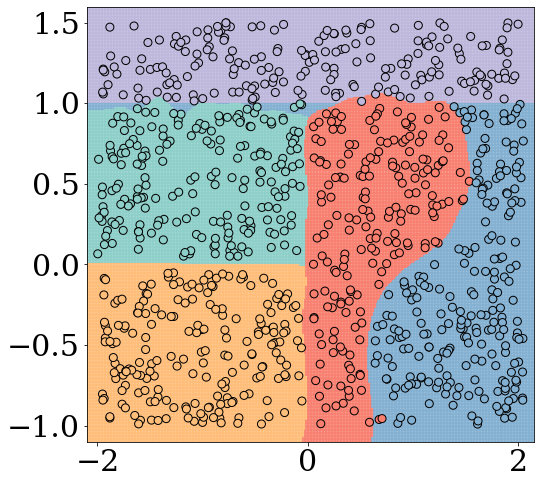

In [183]:

# plot dicision regions
fig, ax = plt.subplots(figsize=FIGSIZE)
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', COLORSCHEME[:5], N=100)
ax.pcolormesh(xx, yy, y_pred, shading='auto', cmap=cmap, alpha=0.8)

# Plot also the testing data points
ax.scatter(x_test[:, 0], x_test[:, 1], c=COLORSCHEME[y_test], edgecolors="k")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()


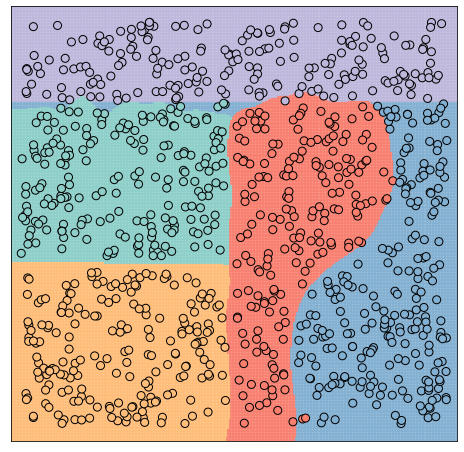

In [188]:

# plot dicision regions
fig, ax = plt.subplots(figsize=FIGSIZE)
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', COLORSCHEME[:5], N=100)
ax.pcolormesh(xx, yy, y_pred, shading='auto', cmap=cmap, alpha=0.8)

# Plot also the testing data points
ax.scatter(x_test[:, 0], x_test[:, 1], c=COLORSCHEME[y_test], edgecolors="k")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xticks(())
plt.yticks(())
plt.show()


# HMR